# DEMO compression & LFI

This demo loads into memory pseudo-cl measurements from simulations, compresses them using neural networks, then uses LFI to estimate the parameters posterior

# load data

In [9]:
import glob
import numpy as np
files = glob.glob('/pscratch/sd/m/mgatti/Anthony/*')

DV2 = []
params_2 = []

DV3 = []
params_3 = []
for file in files:
    if 'lcdm' in file:
        m = np.load(file,allow_pickle = True).item()
        DV2.append(m['output'][0])
        params_2.append([m['output'][1],m['output'][2],m['output'][3]])

    if 'wcdm' in file:
        m = np.load(file,allow_pickle = True).item()
        DV3.append(m['output'][0])
        params_3.append([m['output'][1],m['output'][2],m['output'][3]])

params_3 = np.array(params_3)
params_2 = np.array(params_2)
DV2 = np.array(DV2)
DV3 = np.array(DV3)


In [14]:
np.save('../data/data10k',{'DV2':DV2,'DV3':DV3,'params_3':params_3,'params_2':params_2})

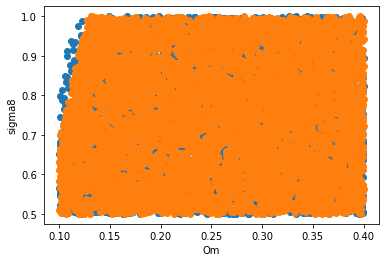

Text(0, 0.5, 'w')

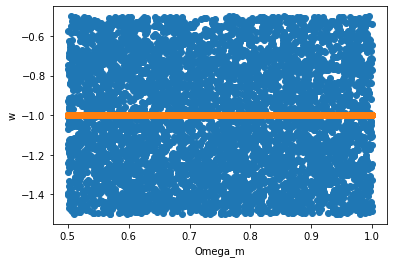

In [2]:
import matplotlib.pyplot as plt
#plot the parameter space spanned by the data
plt.scatter(params_3[:,1],params_3[:,0])
plt.scatter(params_2[:,1],params_2[:,0])
plt.xlabel('Om')
plt.ylabel('sigma8')
plt.show()


#plot the parameter space spanned by the data
plt.scatter(params_3[:,0],params_3[:,2],s=0.5)
plt.scatter(params_2[:,0],params_2[:,2],s=0.5)
plt.xlabel('Omega_m')
plt.ylabel('w')

In [3]:
mask = np.array([True]*int(len(DV3)))
mask[:int(len(DV3)/2)] = False

In [4]:
len(DV2)

7185

# CCA compression

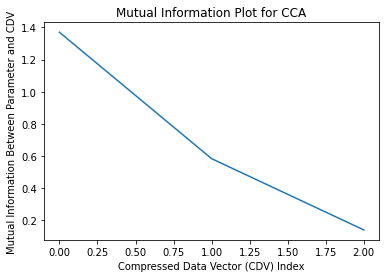

In [5]:
import scipy
from scipy import linalg

# Compute the sampled parameter auto covariance, simulated data vector auto covariance
# and the parameter-data vector cross covariance
cov = np.cov(params_3[mask].T, DV3[mask].T)
cp = cov[:3,:3]
cd = cov[3:,3:]
cpd = cov[:3,3:]

# This 'cl' can be understood as the projection of 'cp' to data vector space
cl = cpd.T@np.linalg.inv(cp)@cpd

# As seen in the paper, this generalized eigenvalue problem is equivalent to CCA
# but is more numerical stable as 'cd' and 'cd-cl' are both invertible.
# This problem is motivated as mutual information maximization under Gaussian linear model assumptions
evals, evecs = linalg.eigh(cd, cd - cl)

# In the context of the CCA, only min( dim(param), dim(data vector) ) components are real and the rest are noise. 
evals = evals[::-1][:3]
evecs = evecs[:,::-1][:,:3]

plt.title("Mutual Information Plot for CCA")
plt.xlabel("Compressed Data Vector (CDV) Index")
plt.ylabel("Mutual Information Between Parameter and CDV")
plt.plot(np.log(evals)/2)
plt.show()



# compresssion 
compressed_dv = DV3@evecs
compressed_dv2 = DV2@evecs



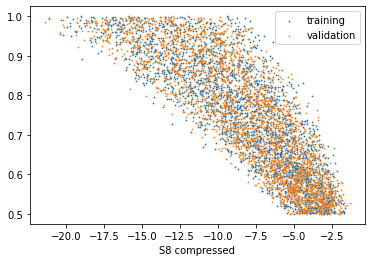

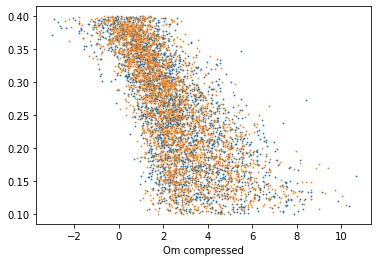

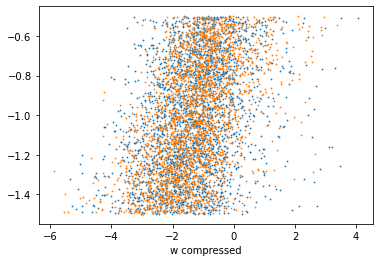

In [6]:
### plot compressed statistics
plt.scatter(compressed_dv[mask,0],params_3[mask][:,0],s=0.6,label = 'training')
plt.scatter(compressed_dv[~mask,0],params_3[~mask][:,0],s=0.6,label = 'validation')
plt.xlabel('S8 sims')
plt.xlabel('S8 compressed')
plt.legend()
plt.show()


plt.scatter(compressed_dv[~mask,1],params_3[~mask][:,1],s=0.6)
plt.scatter(compressed_dv[mask,1],params_3[mask][:,1],s=0.6)
plt.xlabel('Om sims')
plt.xlabel('Om compressed')
plt.show()

plt.scatter(compressed_dv[~mask,2],params_3[~mask][:,2],s=0.6)
plt.scatter(compressed_dv[mask,2],params_3[mask][:,2],s=0.6)
plt.xlabel('w sims')
plt.xlabel('w compressed')
plt.show()


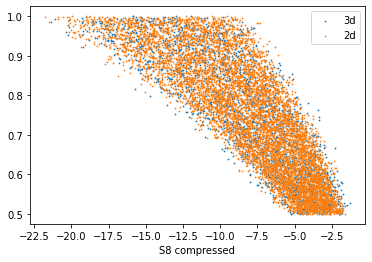

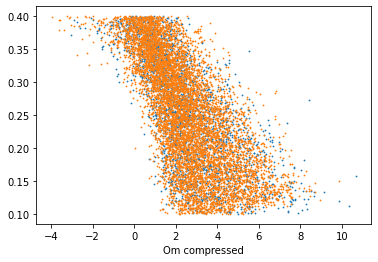

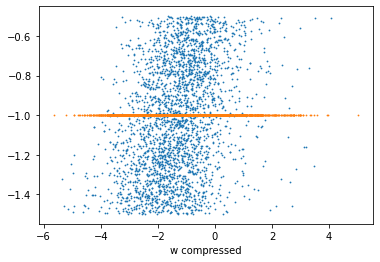

In [7]:
# plot compressed statistics
plt.scatter(compressed_dv[mask,0],params_3[mask][:,0],s=0.6,label = '3d')
plt.scatter(compressed_dv2[:,0],params_2[:,0],s=0.6,label = '2d')
plt.xlabel('S8 sims')
plt.xlabel('S8 compressed')
plt.legend()
plt.show()
plt.scatter(compressed_dv[~mask,1],params_3[~mask][:,1],s=0.6)
plt.scatter(compressed_dv2[:,1],params_2[:,1],s=0.6)
plt.xlabel('Om sims')
plt.xlabel('Om compressed')
plt.show()
plt.scatter(compressed_dv[~mask,2],params_3[~mask][:,2],s=0.6)
plt.scatter(compressed_dv2[:,2],params_2[:,2],s=0.6)
plt.xlabel('w sims')
plt.xlabel('w compressed')
plt.show()


In [8]:
# Define 3 and 2+1 sample that havenot ebeen used for training the compression ~
pue_DV_3 = compressed_dv[~mask,:]
pue_pars3 = params_3[~mask][:,:]

len3 = pue_pars3.shape[0]-200
pue_DV_21 =  np.vstack([compressed_dv2[:len3,:],pue_DV_3[:200]])
pue_pars21 = np.vstack([params_2[:len3,:],pue_pars3[:200]])


len3 = pue_pars3.shape[0]
pue_DV_2 =  compressed_dv2[:len3,:]
pue_pars2 = params_2[:len3,:]


# targets:
target_d_lcdm = compressed_dv2[-1]
target_p_lcdm= params_2[-1]

target_d_wcdm = compressed_dv[-1]
target_p_wcdm= params_3[-1]

# LFI code

In [32]:
# run chain with LFI
import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
import pydelfi.priors as priors
import tensorflow as tf
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import emcee as mc
lower = np.min(pue_pars3,axis=0)
upper = np.max(pue_pars3,axis=0)

lower2 = np.min(pue_pars3[:,:2],axis=0)
upper2 = np.max(pue_pars3[:,:2],axis=0)

theta2d_expected_mean = np.mean(pue_pars3,axis=0)
prior = priors.Uniform(lower, upper)
prior2 = priors.Uniform(lower2, upper2)
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/a
    rray of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

result_dir = '../../../../../../../pscratch/sd/m/mgatti/temp2/'       


count = 0


nn = len(lower)
base = count # any time you re-run it, please increase this by the number of NDEs. Otherwise you'd need to restart the notebook.
count += 3
NDE_3 = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=pue_DV_3.shape[1], n_hiddens=[50,50], n_mades=6, act_fun=tf.tanh, index=base + 0)]
NDE_21 = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=pue_DV_3.shape[1], n_hiddens=[50,50], n_mades=6, act_fun=tf.tanh, index=base + 1)]
NDE_2 = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn-1, n_data=pue_DV_3.shape[1]-1, n_hiddens=[50,50], n_mades=6, act_fun=tf.tanh, index=base + 2)]




pn = ['p{0}'.format(i) for i in range(nn)]


import os
try:
    os.mkdir(result_dir+'/'+str(base))
except:
    pass
try:
    os.system('rm '+result_dir+'/'+str(base)+'/*')
except:
    pass

DelfiEnsemble3 = delfi.Delfi(np.array(np.median(pue_DV_3,axis=0), dtype = 'float'), prior, NDE_3,
                                    param_limits = [lower, upper],
                                    param_names = pn, 
                                    results_dir = result_dir+'/'+str(base)+'/')

DelfiEnsemble3.load_simulations(np.array(pue_DV_3, dtype = 'float'), pue_pars3)
DelfiEnsemble3.train_ndes()

DelfiEnsemble21 = delfi.Delfi(np.array(np.median(pue_DV_21,axis=0), dtype = 'float'), prior, NDE_21,
                                    param_limits = [lower, upper],
                                    param_names = pn, 
                                    results_dir = result_dir+'/'+str(base)+'/')



DelfiEnsemble21.load_simulations(np.array(pue_DV_21, dtype = 'float'), pue_pars21)
DelfiEnsemble21.train_ndes()



pn = ['p{0}'.format(i) for i in range(nn-1)]


DelfiEnsemble2 = delfi.Delfi(np.array(np.median(pue_DV_2[:,:2],axis=0), dtype = 'float'), prior2, NDE_2,
                                    param_limits = [lower2, upper2],
                                    param_names = pn, 
                                    results_dir = result_dir+'/'+str(base)+'/')



DelfiEnsemble2.load_simulations(np.array(pue_DV_2[:,:2], dtype = 'float'), pue_pars2[:,:2])
DelfiEnsemble2.train_ndes()

Training:  17%|█▋        | 87/500 [00:20<00:28, 14.35it/s, train loss=0.875, val loss=0.872]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//0/graph_checkpoint


Training:  22%|██▏       | 111/500 [00:24<00:26, 14.88it/s, train loss=1.18, val loss=1.4] 

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//0/graph_checkpoint


Training:  28%|██▊       | 139/500 [00:32<00:23, 15.52it/s, train loss=0.0987, val loss=0.114] 

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//0/graph_checkpoint


Training:  28%|██▊       | 139/500 [00:33<01:26,  4.16it/s, train loss=0.0987, val loss=0.114]


In [33]:
################################################# LCDM target 
n_dim2d=nn
n_burn2d= 500
n_steps2d = 5000
n_walkers2d = nn * n_dim2d

theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])

def prior_term2d(theta2d):
    p_ = theta2d.T
    for i in range(len(p_)):
        if ((p_[i]<lower[i])|(p_[i]>upper[i])):
            return  - np.inf
    return  0.




def log_posterior2d_temp(theta2d, data):
    return DelfiEnsemble3.log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(target_d_lcdm,))

_ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

final_chain_3_lcdm = sampler2d_.get_chain()




def log_posterior2d_temp(theta2d, data):
    return DelfiEnsemble21.log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(target_d_lcdm,))

_ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

final_chain_21_lcdm = sampler2d_.get_chain()




def prior_term2d(theta2d):
    p_ = theta2d.T
    for i in range(len(p_)):
        if ((p_[i]<lower2[i])|(p_[i]>upper2[i])):
            return  - np.inf
    return  0.



################################################# LCDM target 
n_dim2d=nn-1
n_burn2d= 500
n_steps2d = 5000
n_walkers2d = (nn-1) * n_dim2d

theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])


def log_posterior2d_temp(theta2d, data):
    return DelfiEnsemble2.log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(target_d_lcdm[:2],))

_ = sampler2d_.run_mcmc(theta0_2d[:,:2], n_burn2d+n_steps2d)

final_chain_2_lcdm = sampler2d_.get_chain()

In [34]:
################################################# wCDM target 
n_dim2d=nn
n_burn2d= 2000
n_steps2d = 10000
n_walkers2d = nn * n_dim2d

theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])

def prior_term2d(theta2d):
    p_ = theta2d.T
    for i in range(len(p_)):
        if ((p_[i]<lower[i])|(p_[i]>upper[i])):
            return  - np.inf
    return  0.




def log_posterior2d_temp(theta2d, data):
    return DelfiEnsemble3.log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(target_d_wcdm,))

_ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

final_chain_3_wcdm = sampler2d_.get_chain()




def log_posterior2d_temp(theta2d, data):
    return DelfiEnsemble21.log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(target_d_wcdm,))

_ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

final_chain_21_wcdm = sampler2d_.get_chain()







def prior_term2d(theta2d):
    p_ = theta2d.T
    for i in range(len(p_)):
        if ((p_[i]<lower2[i])|(p_[i]>upper2[i])):
            return  - np.inf
    return  0.



################################################# LCDM target 
n_dim2d=nn-1
n_burn2d= 500
n_steps2d = 5000
n_walkers2d = (nn-1) * n_dim2d

theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])


def log_posterior2d_temp(theta2d, data):
    return DelfiEnsemble2.log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(target_d_wcdm[:2],))

_ = sampler2d_.run_mcmc(theta0_2d[:,:2], n_burn2d+n_steps2d)

final_chain_2_wcdm = sampler2d_.get_chain()

Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 288x288 with 0 Axes>

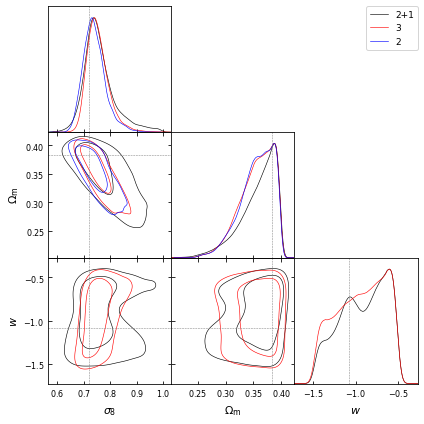

In [36]:
import getdist
from getdist import plots, MCSamples


samples21 = MCSamples(samples=[final_chain_21_wcdm[:,:,0].flatten(),final_chain_21_wcdm[:,:,1].flatten(),final_chain_21_wcdm[:,:,2].flatten()],
                    names = ['s8','Om','w'],labels = [r'\sigma_8',r'\Omega_{\rm m}','w'],
                    label='2+1',
                    settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

samples3 = MCSamples(samples=[final_chain_3_wcdm[:,:,0].flatten(),final_chain_3_wcdm[:,:,1].flatten(),final_chain_3_wcdm[:,:,2].flatten()],
                    names = ['s8','Om','w'],labels = [r'\sigma_8',r'\Omega_{\rm m}','w'],
                    label='3',
                    settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

samples2 = MCSamples(samples=[final_chain_2_wcdm[:,:,0].flatten(),final_chain_2_wcdm[:,:,1].flatten()],
                    names = ['s8','Om'],labels = [r'\sigma_8',r'\Omega_{\rm m}'],
                    label='2',
                    settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

plt.figure(figsize=(4,4))
g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)

g.triangle_plot([samples21,samples3,samples2],['s8','Om','w'],legend_loc='upper right' ,markers = target_p_wcdm) #,shaded=True)
plt.show()



Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 288x288 with 0 Axes>

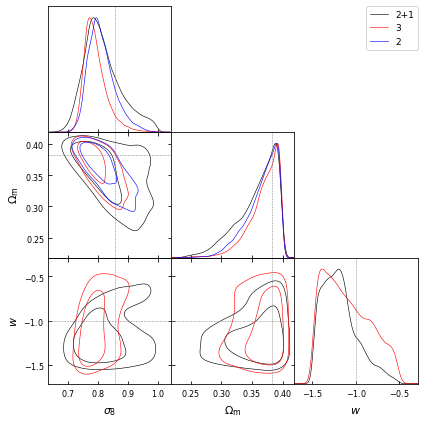

In [39]:
import getdist
from getdist import plots, MCSamples


samples21 = MCSamples(samples=[final_chain_21_lcdm[:,:,0].flatten(),final_chain_21_lcdm[:,:,1].flatten(),final_chain_21_lcdm[:,:,2].flatten()],
                    names = ['s8','Om','w'],labels = [r'\sigma_8',r'\Omega_{\rm m}','w'],
                    label='2+1',
                    settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

samples3 = MCSamples(samples=[final_chain_3_lcdm[:,:,0].flatten(),final_chain_3_lcdm[:,:,1].flatten(),final_chain_3_lcdm[:,:,2].flatten()],
                    names = ['s8','Om','w'],labels = [r'\sigma_8',r'\Omega_{\rm m}','w'],
                    label='3',
                    settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

samples2 = MCSamples(samples=[final_chain_2_lcdm[:,:,0].flatten(),final_chain_2_lcdm[:,:,1].flatten()],
                    names = ['s8','Om'],labels = [r'\sigma_8',r'\Omega_{\rm m}'],
                    label='2',
                    settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

plt.figure(figsize=(4,4))
g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)

g.triangle_plot([samples21,samples3,samples2],['s8','Om','w'],legend_loc='upper right' ,markers = target_p_lcdm) #,shaded=True)
plt.show()
